# Project 1: Linear Regression, Basis Expansion and Regularisation

## Statistical Machine Learning (COMP90051), Semester 2, 2017

*Copyright the University of Melbourne, 2017*

In this project, you will be required to write Python code, and also to answer a few theoretical questions. Your code will be assessed on the basis of (i) whether it works, e.g., does not result in an execution error, and (ii) whether it solves the specified task. It is not important whether your implementation is efficient, as long as it finishes execution within a reasonable amount of time. Note that the worksheet below is a combination of text, pre-implemented code and placeholders where we expect you to add your code and answers. Please follow the instructions carefully, **write your code and give answers only where specifically asked**.

** Marking:** You can get up to 22 marks for Project 1 (*this project*), and up to 33 marks for Project 2. The sum of marks for the two projects is then capped to 50 marks

**Due date:** 5 PM on Monday, the 4th of September 2017 (AEST)

**Late submissions** will incur a 10% penalty per calendar day

** Submission format:** You should use this IPython Notebook worksheet as a starting point, fill in your code and answers where required, and submit the completed worksheet (.ipynb file) via LMS.

**Academic Misconduct:** Your submission should contain only your own work and ideas. Where asked to write code, you cannot re-use someone else's code, and should write your own implementation. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place.

**Table of Contents**

1. Linear Regression Model **(7 marks)**
  1. Analytic Solution
  2. Coordinate Descent Theory
  3. Coordinate Descent Implementation
  
2. Basis Expansion and Regularisation **(7 marks)**
  1. Polynomial Basis Functions
  2. Radial Basis Functions
  3. Ridge Regression

3. Regression on Real Data **(8 marks)**


## 1. Linear Regression Model

We start with setting up working environment.

In [1]:
%pylab
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


Now load some data. In the first two parts of this assignment we will be using a 1D dataset, because it is easy to visualise.

(30, 2)

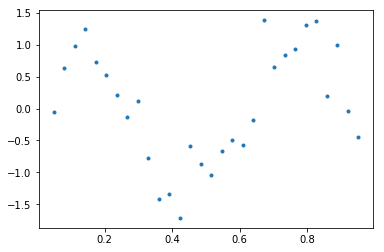

In [2]:
y_synth = np.array([
        -0.05167289, 0.63982603, 0.98123938, 1.24355676, 0.73023443, 0.53273977,
        0.20670524, -0.12854164, 0.12142414, -0.76777309, -1.4140911, -1.33854328,
        -1.71551542, -0.58528115, -0.87024253, -1.03868776, -0.67282369, -0.49697185,
        -0.56960248, -0.18382946, 1.386896, 0.65562566, 0.83638401, 0.94085044,
        1.3127219, 1.37959603, 0.20099471, 0.99189309, -0.04368285, -0.45082514])
# print(y_synth.T.shape)
y_synth = y_synth[:,np.newaxis]
n = y_synth.shape[0]
x_synth = np.linspace(0.05, 0.95, n)
x_synth = x_synth[:,np.newaxis]
# print(x_synth.shape)
# print(y_synth.shape)
plt.plot(x_synth, y_synth, '.')

# add a column of ones as a dummy feature
x_dummy = np.ones(x_synth.shape)
X_synth = np.column_stack((x_dummy, x_synth))
X_synth.shape

Here *x* is the input and *y* the output. Below you will learn models to predict *y* given *x*, using *X_synth* and *y_synth* for training.

**Note:** Do not overwrite global variables *X_synth*, *x_synth* and *y_synth*.

### 1.1 Analytic Solution
In this section, we apply linear regression directly. We will be using a regression with an intercept term. Therefore, despite the data being 1D, there are going to be two parameters.

Implement the analytic solution to linear regression in the following cell. This solution can be found in lecture slides. *Hint: use numpy.linalg.inv to compute matrix inverse.*

**Note:** For this task, you **cannot use** *numpy.linalg.solve*, *numpy.linalg.lstsq* or similar functions that provide an off-the-shelf implementation of the least-squares fit. Other libraries outside of *numpy* and *scipy* are also off limits, here and elsewhere in the project.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

In [3]:
# Input:
# X - is a matrix with N instances in rows and M features in columns
#     constant one column should already be included within X
# y - is an Nx1 column vector with response values
#
# Output:
# w_hat - is an Mx1 column vector with fitted weights
def least_squares_fit(X, y):
    #... your code here ...
    w_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)),X.T),y)
    return w_hat

Now, use your *least_squares_fit* function to fit linear model to the synthetic dataset. Compute and print resulting weights and the corresponding sum of squared residuals (SSR). Plot the data overlaid by the linear fit.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

weight: [[-0.13400438]
 [ 0.39018231]]
SSR: 22.7253309325


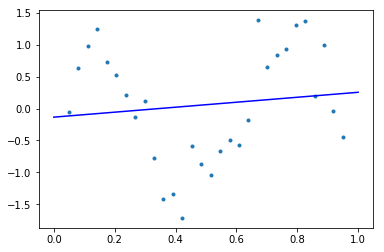

In [4]:
# use "least_squares_fit" function from above
# compute and print resulting weights and the corresponding SSR
# plot the data overlaid by the linear fit

#... your code here ...
w = least_squares_fit(X_synth,y_synth)
SSR = sum((y_synth-np.dot(X_synth, w))**2)
print('weight:',w)
print('SSR:', SSR)
x_test = np.linspace(0, 1, 20)[:, None]
f_test = w[1]*x_test + w[0] 
plt.plot(x_synth, y_synth, '.')
plt.plot(x_test, f_test, 'b-')

This is the best a straightforward linear model can do. You can verify that one cannot do better, by manually changing weights to different values (instead of fitting it automatically). You should not be able to achieve a smaller SSR. The non-linearity in the data can be addressed using basis expansion. But before moving on to this, we will try a different approach to solve linear regression.

### 1.2 Coordinate Descent Theory
In the next two sections, you will derive and implement coordinate descent algorithm for linear regression.

Suppose the training data contains $N$ instances and $M$ features so that $x_{ij}$ denotes the value of feature $j$ for instance $i$. Assume no bias term. Let $y_i$ denote the response value for training instance $i$. Recall that in linear regression, a model with weights $\textbf{w}$ is trained via minimisation of SSR, where the SSR is defined as

$$L( \textbf{w} ) = \sum_{i=1}^N  \left( y_i -  \sum_{j=1}^M w_j x_{ij} \right)^2$$

Let current weight estimates be $w_1,\ldots,w_M$. Consider weight $w_1$, and its coordinate descent update, i.e., the solution for the optimal $w_1$ value that minimises $L(\mathbf{w})$ while all other parameters are fixed. 

Prove that this update is

$$w_1^{new} = \frac{1}{\sum_{i=1}^N x_{i1}^2} \sum_{i=1}^N x_{i1}\left(y_i - \sum_{j=2}^M w_j x_{ij}  \right) $$

This involves partial differentiation of the SSR objective with respect to $w_1$, and equating this with 0. Show at least two intermediate steps. Clearly define any additional symbols that you introduce. Use LaTeX math typesetting.

*Hint: to learn about LaTeX typesetting, see how the above cell is formatted. You can copy and modify the equation above, i.e., ```$$w_1^{new} = \frac{1}{\sum_{i=1}^N x_{i1}^2} \sum_{i=1}^N x_{i1}\left(y_i - \sum_{j=2}^M w_j x_{ij}  \right) $$```.  There are also good tutorials online, e.g., from the [sharelatex](https://www.sharelatex.com/learn/Mathematical_expressions) webpage.*

<font color='red'>**Write your answer here...**</font> (as a *markdown* cell)

$$L( \textbf{w} ) = \sum_{i=1}^N  \left( y_i -  \sum_{j=1}^M w_j x_{ij} \right)^2$$
$$\frac{dL}{dw} = -2\sum_{i=1}^N x_{i,1} \left( y_i -  \sum_{j=1}^M w_j x_{ij} \right)$$
Let
$$\frac{dL}{dw} = 0$$
Then
$$-2\sum_{i=1}^N x_{i,1} \left( y_i -  \sum_{j=1}^M w_j x_{ij} \right) = 0$$
$$\sum_{i=1}^N x_{i,1} y_i = \sum_{i=1}^N x_{i,1} \sum_{j=1}^M w_j x_{ij} $$
$$\sum_{i=1}^N x_{i,1} y_i = \sum_{i=1}^N x_{i,1} (w_1^{new} x_{i,1}+ \sum_{j=2}^M w_j x_{ij}) $$
$$w_1^{new} = \frac{1}{\sum_{i=1}^N x_{i1}^2} \sum_{i=1}^N x_{i1}\left(y_i - \sum_{j=2}^M w_j x_{ij}  \right) $$

### 1.3 Coordinate Descent Implementation

Now implement and run coordinate descent for linear regression.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

In [5]:
# Input:
# X - is a matrix with N instances in rows and 2 columns,
#     one of which is the constant one column
# y - is an Nx1 column vector with response values
# j - is the index of the weight to be updated, j=0,1
# w_curr - is an 2x1 column vector with the current estimate of weights
#
# Output:
# w_j_new - is a scalar containing the updated value of the j-th component
def coord_descent_iteration(X, y, j, w_curr):
    #... your code here ... 
#     print(j)
#     print(w_curr)
#     print(w_curr[1-j]*X[:,j])
#     print(X[:,j+1])
    #print((y[:,0]-w[1-j]*X[:,1-j]).shape)
    w_j_new = 1/sum(X[:,j]**2)*sum((X[:,j]*(y[:,0]- w_curr[1-j]*X[:,1-j])))
    #print(w_j_new)
    return w_j_new

Use the code below to test your coordinate descent method.

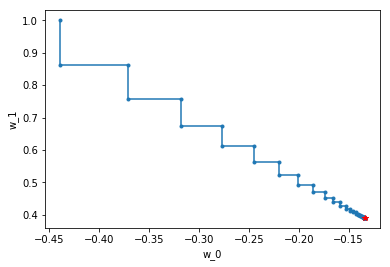

In [6]:
# coordinate descent
n_epochs = 100
n_features = X_synth.shape[1]

# starting guess
w_current = np.array([1, 1], dtype='float')
w_current.shape = (2,1)

# keep track of iterative improvement
w_trace = np.zeros((2, n_epochs*n_features))
trace_step = 0

for i in range(n_epochs):
    for j in range(n_features):
        w_j_new = coord_descent_iteration(X_synth, y_synth, j, w_current)
        w_current[j] = w_j_new;
        w_trace[:,trace_step] = w_current[:,0]
        trace_step += 1

# analytic solution
w_hat = least_squares_fit(X_synth, y_synth)
# plot results
plt.plot(w_trace[0,:], w_trace[1,:], '.-')
plt.plot(w_hat[0], w_hat[1], 'r*')
plt.xlabel('w_0')
plt.ylabel('w_1')

## 2. Basis Expansion and Regularisation

The dataset provided is not well modelled by a linear regression. We will now look at more advanced techniques for modelling the data using richer basis functions to represent the input, thus learning non-linear regression functions.

### 2.1 Polynomial Basis Functions

In this section, we explore polynomial basis functions. These basis functions are fairly straightforward for 1D data, as illustrated in the example snippet below.

original example point x = 0.5
transformed example point phi(x) = [[ 0.5      0.25     0.125    0.0625   0.03125]]


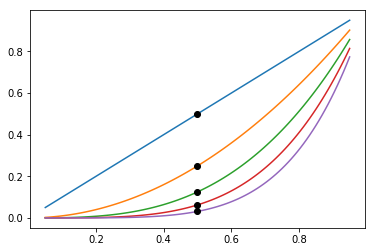

In [7]:
# plot polynomial functions, and a value of example input point
x_example = 0.5

n_poly = 5

x_poly = np.linspace(0.05, 0.95, 100)
x_phi = np.empty((n_poly, 1))

for i in range(n_poly):
    y_poly = x_poly ** (i + 1)
    v = x_example ** (i + 1)
    x_phi[i] = v
    plt.plot(x_poly, y_poly)
    plt.plot(x_example, v, 'ko')
    
print('original example point x =', x_example)
print('transformed example point phi(x) =', np.transpose(x_phi))

Note that the example point is 1D in original feature space, and 5D in the new feature space.

Your task is to implement a method to apply a $M^{th}$ order polynomial expansion to a 1D input vector.

<br>
<font color='red'>**Write your code in the cell below ...**</font>

In [8]:
# Input:
# x - is an Nx1 column vector of features
# M - is the maximum polynomial degree, the new basis
#     should include M polynomials with degrees from 1 to M
#
# Output:
# Phi - is a NxM matrix of data in transformed feature space
#       dummy feature is not included
def expand_1d_to_poly(x, M):
    #... your code here ...
    Phi = x
    for i in range(1,M):
        Phi = np.column_stack((Phi, x ** (i + 1)))
    return Phi

Now, apply the transformation and use your *least_squares_fit* function to fit linear model in the transformed feature space. Do not forget to add the dummy variable. Compute and print resulting weights and the corresponding SSR. Plot original 1D data overlaid by the  fit.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

3.30838852233
[[  -2.30242362]
 [  61.08670566]
 [-361.59408779]
 [ 784.47526064]
 [-699.33469842]
 [ 216.01839742]]


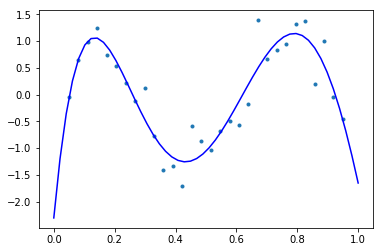

In [9]:
# use some maximum degree M > 2

# use "expand_1d_to_poly" function from above
# use "least_squares_fit" function from above

# compute and print resulting weights and the corresponding SSR
# plot the data overlaid by the fit

#... your code here ...
# add a column of ones as a dummy feature
# print(x_synth)
x_synth_poly = expand_1d_to_poly(x_synth, 5)
x_dummy_poly = np.ones(x_synth.shape)
X_synth_poly = np.column_stack((x_dummy_poly, x_synth_poly))
# print(X_synth_poly)
# print(X_synth_poly.shape)
# print(X_synth.shape)
w_poly = least_squares_fit(X_synth_poly,y_synth)
SSR = sum((y_synth-np.dot(X_synth_poly,w_poly))**2)
print(SSR)
print(w_poly)
# print(X_synth_poly)
# print(np.dot(X_synth_poly,w_poly))
# print(np.dot(w_poly[:,0], X_synth_poly.T))
x_test_poly = np.linspace(0, 1, 50)[:, None]
x_test_poly1 = expand_1d_to_poly(x_test_poly,5)
x_test_dummy_poly = np.ones(x_test_poly.shape)
X_test_poly = np.column_stack((x_test_dummy_poly, x_test_poly1))
#print(X_test_poly)
f_test_poly = np.dot(w_poly.T ,X_test_poly.T )[0][:,np.newaxis]
# print(f_test_poly)
plt.plot(x_synth, y_synth, '.')
plt.plot(x_test_poly, f_test_poly, 'b')

Note that the fit is now non-linear in the original features space.

### 2.2 Radial Basis Functions

Another popular choice for basis expansion is radial basis functions (RBF). For our synthetic 1D data, we will use an RBF defined as $v(x)=\exp \left(-\frac{1}{\sigma}||x - z||^2\right)$. Parameter $z$ controls the location of the function, and $\sigma$ controls the spread. This function is implemented below.

In [10]:
# Input:
# x - is a column vector of input values
# z - is a scalar that controls location
# s - is a scalar that controls spread
#
# Output:
# v - contains the values of RBF evaluated for each element x
#     v has the same dimensionality as x
def radial_basis_function(x, z, s):
    # ensure that t is a column vector
    x = np.array(x)
    if x.size == 1:
        x.shape = (1,1)
    else:
        x_length = x.shape[0]
        x.shape = (x_length, 1)
    
    # compute RBF value
    r = np.linalg.norm(x - z, 2, 1)
    v = np.exp(-r**2/s)
    return v

Now use the code below to plot some RBF functions.

[ 0.    0.25  0.5   0.75  1.  ]


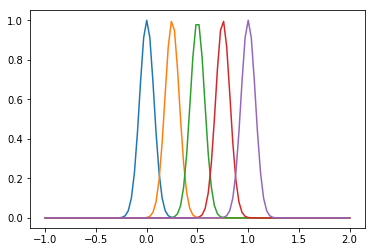

In [11]:
# number of RBF
n_rbf = 5

# locations and scale
z = np.linspace(0, 1, n_rbf)
print(z)
sigma = 0.01 # same scale for each RBF

x_rbf = np.linspace(-1, 2, 100)
x_rbf = np.transpose(x_rbf)
for i in range(n_rbf):
    y_rbf = radial_basis_function(x_rbf, z[i], sigma)
    plt.plot(x_rbf, y_rbf)

Given an example point, visualise values of that point in the RBF space

original example point x = 0.5
transformed example point phi(x) = [[  1.38879439e-11   1.93045414e-03   1.00000000e+00   1.93045414e-03
    1.38879439e-11]]


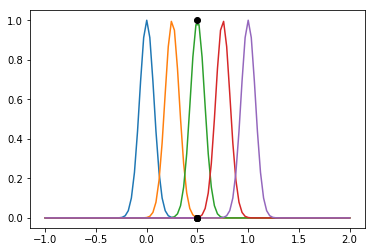

In [12]:
x_example = 0.5

# number of RBF
n_rbf = 5

# locations and scale
z = np.linspace(0, 1, n_rbf)
sigma = 0.01 # same scale for each RBF

x_rbf = np.linspace(-1, 2, 100)
x_rbf = np.transpose(x_rbf)

x_phi = np.zeros((n_rbf, 1))
for i in range(n_rbf):
    y_rbf = radial_basis_function(x_rbf, z[i], sigma)
    v = radial_basis_function(x_example, z[i], sigma)
    x_phi[i] = v
    plt.plot(x_rbf, y_rbf)
    plt.plot(x_example, v, 'ko')
print('original example point x =', x_example)
print('transformed example point phi(x) =', np.transpose(x_phi))

Note that the example point is 1D in original feature space, and 5D in the new feature space.

Now implement feature space transformation using RBFs.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

In [13]:
# Input:
# x - is an Nx1 column vector
# z - is an Mx1 column vector with locations for each of M RBFs
# s - is a scalar that controls spread, shared between all RBFs
#
# Output:
# Phi - is an NxM matrix, such that Phi(i,j) is the 
#       RBF transformation of x(i) using location z(j) and scale s
def expand_1d_to_RBF(x, z, s):
    #... your code here ...
    #... in your code use "radial_basis_function" from above ...
    n_rbf = len(z)
    Phi = np.zeros((n_rbf, len(x)))
    for i in range(n_rbf):
        v = radial_basis_function(x, z[i], sigma)
        Phi[i] = v
    return Phi

Now, apply the RBF transformation and use your *least_squares_fit* function to fit linear model in the transformed feature space. Do not forget to add the dummy variable. Compute and print resulting weights and the corresponding SSR. Plot original 1D data overlaid by the  fit.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

3.55624203313
[[-24.21123399]
 [ 17.72837844]
 [  8.54666599]
 [  9.91252297]
 [ 11.18194474]
 [ 15.01055563]]


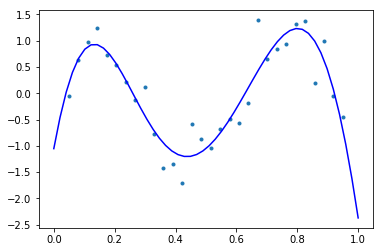

In [14]:
# you can use the same number of RBFs, their
# locations and scale as in the previous plot

# use "expand_1d_to_RBF" function from above
# use "least_squares_fit" function from above

# compute and print resulting weights and the corresponding SSR
# plot the data overlaid by the fit

# number of RBF
n_rbf = 5

# locations and scale
z = np.linspace(0, 1, n_rbf)
sigma = 0.1 # same scale for each RBF

#... your code here ...
# x_synth_poly = expand_1d_to_poly(x_synth, 5)
# x_dummy_poly = np.ones(x_synth.shape)
# X_synth_poly = np.column_stack((x_dummy_poly, x_synth_poly))

x_synth_rbf = expand_1d_to_RBF(x_synth, z, sigma)
# print(x_synth)
x_dummy_rbf = np.ones(x_synth.shape)
# print(x_synth_rbf)
# print(x_dummy_rbf)
x_synth_rbf = np.transpose(x_synth_rbf)
X_synth_rbf = np.column_stack((x_dummy_rbf, x_synth_rbf))

#print(X_synth)
# print(X_synth_rbf)
w_rbf = least_squares_fit(X_synth_rbf,y_synth)
SSR = sum((y_synth-np.dot(X_synth_rbf,w_rbf))**2)
print(SSR)
print(w_rbf)

# x_test_poly = np.linspace(0, 1, 50)[:, None]
# x_test_poly1 = expand_1d_to_poly(x_test_poly,5)
# x_test_dummy_poly = np.ones(x_test_poly.shape)
# X_test_poly = np.column_stack((x_test_dummy_poly, x_test_poly1))

x1_test_rbf = np.linspace(0, 1, 50)[:, None]
x_test_rbf = expand_1d_to_RBF(x1_test_rbf, z, sigma)
x_test_rbf = np.transpose(x_test_rbf)
x_test_dummy_rbf = np.ones(x_test_rbf.shape[0])

X_test_rbf = np.column_stack((x_test_dummy_rbf, x_test_rbf))
#print(X_test_rbf.shape)

f_test_rbf = np.dot(X_test_rbf,w_rbf )
#print(f_test_rbf.shape)
plt.plot(x_synth, y_synth, '.')
plt.plot(x1_test_rbf, f_test_rbf, 'b')

### Analysis

Compare the three methods of regression on this dataset: plain linear approach, polynomial basis expansion, and RBF basis expansion. For each method, name at least one aspect in which this method is advantageous compared to the other two methods. Justify your answer.

*Hint: think about making predictions outside the range of training data.*

<font color='red'>**Write your answer here (a short paragraph or two).**</font> (as a *markdown* cell)

#### Answer:

##### Plain linear regression:
[Advantage]: Less overfitting. It is a more general model which can show the basic trend of the dataset. May have better performance outside the training data in general. If we make predictions outside the range of training data, it might still fits the model well.

[Disadvantage]: May be underfitting. Bad performance with training data. The result of loss function can be large.

##### Polynomial basis expansion:

[Advantage]: The result model fits the training data very well. Especially good performance reflecting the trend of training data.

[Disadvantage]: As the dimension increases, it is easy to get overfitting. Test error may be larger when maximum polynomial degree is big.If we make predictions outside the range of training data, it might not fits the model well.


##### RBF basis expansion:
RBF is similar to polynomial basis expansion.


[Advantage]: The result model fits the training data very well. Especially good performance reflecting the trend of training data.

[Disadvantage]: As the dimension increases, it is easy to get overfitting.

According to "Taylor Series", the RBF $v(x)=\exp \left(-\frac{1}{\sigma}||x - z||^2\right)$ can be expanded to infinit polynomial space based on  the following formula:

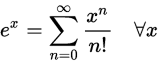

That is to say, it has the similar advantage with polynomial basis function of fitting training data. However, it still have to problem of overfitting. The overfitting of RBF can be worse than polynomial basis expansion.



### 2.3 Ridge Regression

In this section, we are going to use ridge regression to achieve two goals: (i) resistance to irrelevant features and (ii) control over the model complexity.

Our current solution cannot handle irrelevant features. For example, if matrix with data contains duplicate columns (features), the operation of taking the inverse will result in an execution error. Note that computing matrix inverse with nearly collinear (irrelevant) features will not result in an execution error, but might produce a nonsense result. Methods for detecting near collinearity are outside the scope of this project. Therefore, if you suspect (near) collinearity, use one of regularisation methods, e.g., ridge regression.

Implement ridge regression. *Hint: use np.linalg.inv*

**Note:** For this task, you **cannot use** *sklearn.linear_model.Ridge*, *numpy.linalg.lstsq* or similar functions that provide an off-the-shelf implementation of ridge regression.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

In [15]:
# Input:
# X - is a matrix with N instances in rows and M features in columns
#     constant one column should already be included within X
# y - is an Nx1 column vector with response values
# l - is a scalar, regularisation parameter
#
# Output:
# w_hat - is an Mx1 column vector with fitted weights
def reg_least_squares_fit(X, y, l):
    #... your code here ...
    
    w_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+ l*np.identity(np.dot(X.T, X).shape[0])),X.T),y)
    return w_hat

Next, we are going to use held-out validation in order to assess the ability of our model to *extrapolate*. We will control model complexity using your implementation of ridge regression implemented.

Plot train and test error as a function of the regularisation parameter.

<br>

<font color='red'>**Complete the code below ...**</font>

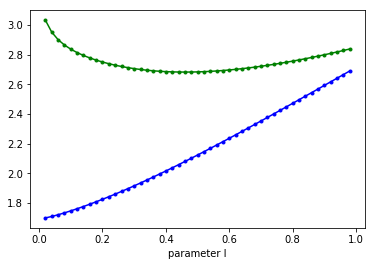

In [16]:
# students to write this code

# fill in the gaps
# use "expand_1d_to_RBF" and "reg_least_squares_fit" functions from above
# do not forget to add a dummy variable

# number of RBF
n_rbf = 10

# locations and scale
z = np.linspace(0, 1, n_rbf)
sigma = 0.01 # same scale for each RBF

# train and test split for the purpose of extrapolation
np.random.seed(2017) # for reproducibility
n_instances = x_synth.shape[0]
idx_train = range(0, n_instances, 2)
idx_test = range(1, n_instances, 2)
x_synth_train = x_synth[idx_train,:]
y_synth_train = y_synth[idx_train,:]

# ... your code here ...
x_train_rr = expand_1d_to_RBF(x_synth_train, z, sigma)
x_train_rr = np.transpose(x_train_rr)
x_train_dummy_rr = np.ones(x_synth_train.shape[0])
X_train_rr = np.column_stack((x_train_dummy_rr, x_train_rr))


x_synth_test = x_synth[idx_test,:]
y_synth_test = y_synth[idx_test,:]

# ... your code here ...
x_test_rr = expand_1d_to_RBF(x_synth_test, z, sigma)
x_test_rr = np.transpose(x_test_rr)
x_test_dummy_rr = np.ones(x_synth_test.shape[0])
X_test_rr = np.column_stack((x_test_dummy_rr, x_test_rr))



# vary the regularisation parameter
l_start = 0.02
l_stop = 1
l_step = 0.02

l_values = []
ssr_trend_train = []
ssr_trend_test = []

l = l_start
while l <= l_stop:
    #... your code here ...
    w_hat = reg_least_squares_fit(X_train_rr, y_synth_train, l)
    #train SSR
    ssr_train = sum((y_synth_train-np.dot(X_train_rr, w_hat))**2)
    ssr_trend_train.append(ssr_train)
    # test SSR
    ssr_test = sum((y_synth_test-np.dot(X_test_rr, w_hat))**2)
    ssr_trend_test.append(ssr_test)
    
    
    l_values.append(l)
    l += l_step

plt.plot(l_values, ssr_trend_train, '.-b')
plt.plot(l_values, ssr_trend_test, '.-g')
plt.xlabel('parameter l')

## 3. Regression on Real Data

In the final part of this project, we will work with a real-world dataset. Here, we will use linear regression to predict petrol consumption in liters per 10 km from the following features: number of cylinders, displacement, horsepower, weight, acceleration, model year. All of these features are different characteristics of cars. The exact meaning of each quantity is not important for the task. Run the following cell to load the data into variables *X_real* (cars in rows and features in columns) and *y_real* (response values).

In [17]:
X_real = np.array([
[6.0, 250.0, 72.0, 3432.0, 21.0, 75.0],
[6.0, 250.0, 100.0, 3282.0, 15.0, 71.0],
[6.0, 231.0, 110.0, 3415.0, 15.8, 81.0],
[4.0, 140.0, 75.0, 2542.0, 17.0, 74.0],
[8.0, 351.0, 158.0, 4363.0, 13.0, 73.0],
[4.0, 68.0, 49.0, 1867.0, 19.5, 73.0],
[8.0, 318.0, 150.0, 4190.0, 13.0, 76.0],
[8.0, 318.0, 140.0, 3735.0, 13.2, 78.0],
[6.0, 156.0, 122.0, 2807.0, 13.5, 73.0],
[4.0, 97.0, 60.0, 1834.0, 19.0, 71.0],
[8.0, 302.0, 139.0, 3570.0, 12.8, 78.0],
[6.0, 232.0, 100.0, 2789.0, 15.0, 73.0],
[4.0, 91.0, 53.0, 1795.0, 17.5, 75.0],
[6.0, 198.0, 95.0, 2833.0, 15.5, 70.0],
[4.0, 97.0, 78.0, 2300.0, 14.5, 74.0],
[8.0, 318.0, 210.0, 4382.0, 13.5, 70.0],
[6.0, 198.0, 95.0, 3102.0, 16.5, 74.0],
[8.0, 454.0, 220.0, 4354.0, 9.0, 70.0],
[6.0, 232.0, 100.0, 2634.0, 13.0, 71.0],
[4.0, 85.0, 70.0, 2070.0, 18.6, 78.0],
[8.0, 318.0, 150.0, 3436.0, 11.0, 70.0],
[4.0, 97.0, 88.0, 2279.0, 19.0, 73.0],
[4.0, 121.0, 110.0, 2660.0, 14.0, 73.0],
[6.0, 225.0, 85.0, 3465.0, 16.6, 81.0],
[4.0, 105.0, 63.0, 2125.0, 14.7, 82.0],
[8.0, 400.0, 150.0, 4997.0, 14.0, 73.0],
[8.0, 318.0, 140.0, 4080.0, 13.7, 78.0],
[4.0, 112.0, 85.0, 2575.0, 16.2, 82.0],
[4.0, 98.0, 68.0, 2135.0, 16.6, 78.0],
[6.0, 225.0, 100.0, 3651.0, 17.7, 76.0],
[8.0, 340.0, 160.0, 3609.0, 8.0, 70.0],
[8.0, 400.0, 167.0, 4906.0, 12.5, 73.0],
[6.0, 200.0, 85.0, 2990.0, 18.2, 79.0],
[4.0, 140.0, 90.0, 2264.0, 15.5, 71.0],
[4.0, 151.0, 90.0, 2670.0, 16.0, 79.0],
[8.0, 350.0, 145.0, 4055.0, 12.0, 76.0],
[6.0, 258.0, 110.0, 3730.0, 19.0, 75.0],
[6.0, 231.0, 115.0, 3245.0, 15.4, 79.0],
[4.0, 91.0, 68.0, 2025.0, 18.2, 82.0],
[6.0, 231.0, 105.0, 3380.0, 15.8, 78.0],
[6.0, 168.0, 116.0, 2900.0, 12.6, 81.0],
[8.0, 318.0, 150.0, 3399.0, 11.0, 73.0],
[8.0, 400.0, 175.0, 5140.0, 12.0, 71.0],
[8.0, 429.0, 198.0, 4952.0, 11.5, 73.0],
[8.0, 302.0, 140.0, 4294.0, 16.0, 72.0],
[8.0, 302.0, 140.0, 4638.0, 16.0, 74.0],
[8.0, 455.0, 225.0, 4425.0, 10.0, 70.0],
[4.0, 140.0, 90.0, 2408.0, 19.5, 72.0],
[4.0, 120.0, 88.0, 2957.0, 17.0, 75.0],
[6.0, 171.0, 97.0, 2984.0, 14.5, 75.0],
])

y_real = np.array([63.8, 80.8, 95.2, 106.3, 55.3, 123.3, 68.0, 82.5, 85.0, 114.8, 85.9, 76.5, 140.3, 93.5, 110.5, 46.8, 85.0, 59.5, 80.8, 167.5, 76.5, 85.0, 102.0, 74.8, 161.6, 46.8, 74.4, 131.8, 125.4, 85.0, 59.5, 51.0, 84.2, 119.0, 120.7, 55.3, 63.8, 91.4, 157.3, 87.6, 108.0, 63.8, 55.3, 51.0, 55.3, 59.5, 59.5, 85.0, 97.8, 76.5, ])
y_real.shape = (X_real.shape[0], 1)

For each step below, where answer is required, write no more than a few sentences. You can interleave code cells with markdown cells containing your answers. *Make it clear which of the questions 3.1 ... 3.3 each of your cell answers.*

**3.1** Do you think that any preprocessing is required for this dataset? Explain your answer.

**3.2** Fit ridge regression without any basis expansion. Set regularisation parameter to 0.01. Do you think a plain linear model is adequate for this dataset? Justify your answer, e.g., using a plot that characterises resulting fit.

**3.3** Fit ridge regression in transformed feature space. You can use any feature transformation (polynomial, RBF or anything else). Justify your choice of the regularisation parameter. Compare results from steps 3.2 and 3.3. Do you think your results are reasonably good? Justify your answer. *Hint: think about prediction error per 10 liters*


<br>

<font color='red'>**Write your code and answers below ...**</font> (use both code cells and markdown cells)

**Answer**

**3.1** (Do you think that any preprocessing is required for this dataset? Explain your answer.)

The preprocessing is required. Dummy variables should be added to the matrix. Using the dummy value is a clever way to merge the constant in linear equations (e.g. 'b' in y = a*x + b) into the weight array w_hat.

Also normalizing the training data for each feature can be done in the preprocess. For the RBF expansion analysis in section 3.3, the normalization process is done to limit the value of each attributes to the range between 0 and 1 in order to fit the parameters.


In [18]:
# Add dummy value to the vector
x_real_dummy = np.ones(X_real.shape[0])
x_real = np.column_stack((x_real_dummy, X_real))
print(x_real.shape)

(50, 7)


**3.2** Ridge regression
(Fit ridge regression without any basis expansion. Set regularisation parameter to 0.01. Do you think a plain linear model is adequate for this dataset? Justify your answer, e.g., using a plot that characterises resulting fit.)


First of all, we use ridge regression without any expansion to generate the weights and predicted value. The Lamda value is 0.01 for regularization. 

The SSR value is about 7410. Because we do not have any other models to compare, it is hard to tell whether this SSR is small or big.
Also, the visualization of this multi-dimensional data is also hard to visualize. 

Here we use "Standardized residuals vs fitted plot" to show the relationship between predicted value and standardized residuals.
"Residual" is the difference between real value and predicted value, which is y_real minus predicted value in our case.
Standardized residual is a normalized residual. Here we use the formular: 

standardized_residual = residual/(standard deriviation of residual)

The method of 'standardized residuals vs fitted plot' reduces the dimensions of the data and makes it easier to be visualized. 

According to the graph, a plain linear model is not adequate for this dataset. The reason is that there is an obvious pattern in the plot below. We will analys the pattern while comparing with polynomial basis expansion in 3.3.

Estimated weights:  [[  2.75650546e+00  -7.90287270e+00   1.35518369e-03   7.33017041e-02
   -1.79480753e-02  -1.53708927e+00   2.75284838e+00]]
Estimated SSR:  7410.88387859


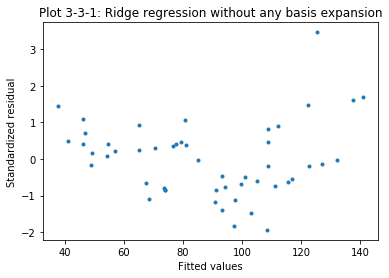

In [19]:
"""Ridge regression without any basis expansion"""
w_hat = reg_least_squares_fit(x_real, y_real, 0.02)
f_real_plain = np.dot(x_real,w_hat)
SSR_plain = sum((y_real-f_real_plain)**2)
residuals_plain  = y_real - f_real_plain
stan_residuals_plain = (residuals_plain*1.0) /np.std(residuals_plain )
print('Estimated weights: ', w_hat.T)
print('Estimated SSR: ',SSR_plain)
plt.ylabel('Standardized residual')
plt.xlabel('Fitted values')
plt.title('Plot 3-3-1: Ridge regression without any basis expansion')
plt.plot(f_real_plain, stan_residuals_plain,'.')



#### 3.3 Ridge Regression with RBF
(Fit ridge regression in transformed feature space. You can use any feature transformation (polynomial, RBF or anything else). Justify your choice of the regularisation parameter. Compare results from steps 3.2 and 3.3. Do you think your results are reasonably good? Justify your answer. *Hint: think about prediction error per 10 liters*)

In this section, we still use Standardized residual vs fitted plot to visualize relationship between error and fitted value. If a model is good enough, the errorness should be normally distributed when fitted value changes.

There are two plots below showing how good the regression models are. In case 1,the mean residual and spread doesn't change with the fitted values. This means the model is adequate for the dataset. However in case 2, the mean residual is small when fitted value is smaller than -2 or larger than 2, and it is larger in area (-2,2). The pattern shows the hidden relationship between error and fitted value, which indicates the regression model is not adequate for the dataset.

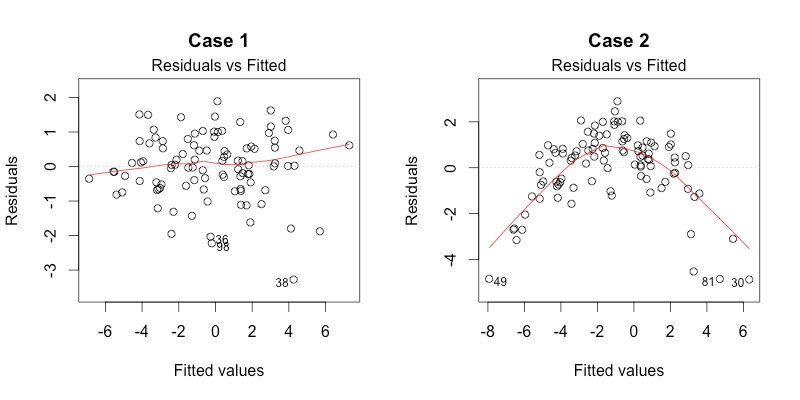

In order to do the comparison between "Ridge regression without any basis expansion" and "Ridge regression with polynomial basis expansion", we need to do another regression process for the data points in  residuals vs fitted plot, in order to generate the red line in the plots above to show the effectiveness of models. First, we use data in 3.2 ("Ridge regression without any basis expansion") to generate the red line showing the trend residuals change when fitted values changes.

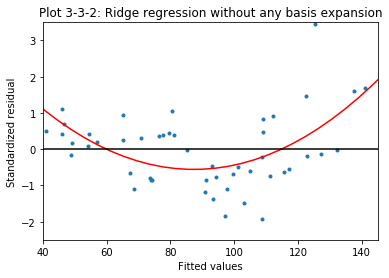

In [20]:
"""Ridge regression without any basis expansion"""
f_real = f_real_plain
stan_residuals = stan_residuals_plain
x_synth_poly = expand_1d_to_poly(f_real,2 )
x_dummy_poly = np.ones(f_real.shape)
X_synth_poly = np.column_stack((x_dummy_poly, x_synth_poly))
w_poly = least_squares_fit(X_synth_poly,stan_residuals)
SSR = sum((stan_residuals-np.dot(X_synth_poly,w_poly))**2)
# print(SSR)
# print(w_poly)
x_test_poly = np.linspace(0, 200, 50)[:, None]
x_test_poly1 = expand_1d_to_poly(x_test_poly,2)
x_test_dummy_poly = np.ones(x_test_poly.shape)
X_test_poly = np.column_stack((x_test_dummy_poly, x_test_poly1))
f_test_poly = np.dot(w_poly.T ,X_test_poly.T )[0][:,np.newaxis]
plt.plot(f_real, stan_residuals,'.')
plt.ylim([-2.5,3.5])
plt.xlim([40,145])
plt.plot(x_test_poly, f_test_poly, 'r')
plt.plot(x_test_poly, np.zeros(f_test_poly.size), 'black')
plt.ylabel('Standardized residual')
plt.xlabel('Fitted values')
plt.title('Plot 3-3-2: Ridge regression without any basis expansion')

Now we do the Ridge regression with polynomial basis expansion using the real data. In this process, the "l" parameter is chosen based on the SSR result. The "l" value with the least SSR value is chosed after the iteration, which is 0.02 in this case.

Best lamda value:  0.02
Best SSR value:  2994.87005324


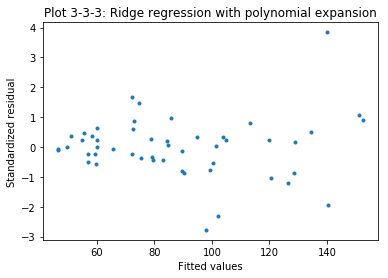

In [21]:
"""Polynomial"""
x_synth_real = expand_1d_to_poly(x_real, 5)
x_dummy_real = np.ones(x_real.shape)
X_synth_real = np.column_stack((x_dummy_real, x_synth_real))
w_optimal =  reg_least_squares_fit(X_synth_real, y_real, 0.00)
f_real = np.dot(X_synth_real,w_optimal)
SSR_optimal = sum((y_real-f_real)**2)
l_optimal = 0.00
for i in range(1,100):
    l = (i*0.01)
    w_hat = reg_least_squares_fit(X_synth_real, y_real, l)
    f_real = np.dot(X_synth_real,w_hat)
    SSR = sum((y_real-f_real)**2)
    if(SSR < SSR_optimal):
        w_optimal = w_hat
        SSR_optimal = SSR
        l_optimal = l
f_real = np.dot(X_synth_real,w_optimal)
SSR_optimal = sum((y_real-f_real)**2)
plt.plot(f_real,(y_real-np.dot(X_synth_real,w_hat))/np.std((y_real-np.dot(X_synth_real,w_hat))),'.')
# print(w_optimal)
print('Best lamda value: ',l_optimal)
print('Best SSR value: ',SSR_optimal)
plt.ylabel('Standardized residual')
plt.xlabel('Fitted values')
plt.title('Plot 3-3-3: Ridge regression with polynomial expansion')
residuals  = y_real - f_real
stan_residuals = (residuals*1.0) /np.std(residuals )

Now we do the same quadratic regression for standardized residual vs fitted plot.

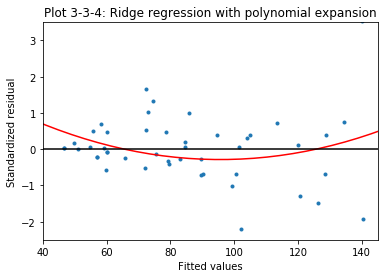

In [22]:
x_synth_poly = expand_1d_to_poly(f_real,2 )
x_dummy_poly = np.ones(f_real.shape)
X_synth_poly = np.column_stack((x_dummy_poly, x_synth_poly))
w_poly = least_squares_fit(X_synth_poly,stan_residuals)
SSR = sum((stan_residuals-np.dot(X_synth_poly,w_poly))**2)
# print(SSR)
# print(w_poly)
x_test_poly = np.linspace(0, 200, 50)[:, None]
x_test_poly1 = expand_1d_to_poly(x_test_poly,2)
x_test_dummy_poly = np.ones(x_test_poly.shape)
X_test_poly = np.column_stack((x_test_dummy_poly, x_test_poly1))
f_test_poly = np.dot(w_poly.T ,X_test_poly.T )[0][:,np.newaxis]
plt.plot(f_real, stan_residuals,'.')
plt.ylim([-2.5,3.5])
plt.xlim([40,145])
plt.plot(x_test_poly, f_test_poly, 'r')
plt.plot(x_test_poly, np.zeros(f_test_poly.size), 'black')
plt.ylabel('Standardized residual')
plt.xlabel('Fitted values')
plt.title('Plot 3-3-4: Ridge regression with polynomial expansion')

** Comparisons: **

The SSR of 'Ridge regression without basis expansion' is more than 7000. After adding the polynomial expansion, it decreases to less tan 3000. The errorness of regression is lowered down by using feature transformation. This shows the better performance of using polynomial expansion than using plain regression. 

Comparing the red curve between two plots 3-3-2 and 3-3-4, the model of 'Ridge regression with polynomial expansion' shows less pattern of distribution than 'Ridge regression without basis expansion'. 

In plot 3-3-2, the non-linear relationship was not explained by the model and was left out in the residuals, which shows the model is not adequate enough. 

In plot 3-3-4, the  mean residual and spread doesn't change much with the fitted values, which shows that the model does not have much problem to.

In conculusion, ridge regression with polynomial basis function models the data in a better way.







**Additional Work**

In order to compare RBF with Polynomial expansion, real data is also tested by linear regression with RBF expansions. 

The process of training and validating are similar to using polynomial expansion above, which is to calculate the standardized residuals for the dataset in order to generate the "Standardized Residuals vs Fitted Plot".


(50, 30)
RBF SSR: 2930.79456734
w: [[  5.06832288e+01   5.96258813e-10   8.28812551e-02   4.29395305e+01
    3.18680284e+00   4.66071183e+00   1.55278124e+01  -2.75435525e+01
   -1.46355907e+01  -2.02376796e+01   8.04565198e-01  -1.67354178e+00
    4.93385043e+01   1.93959155e+01  -1.54445380e+00  -2.79803212e+01
   -1.13985983e-03  -2.15805884e+01  -3.58860164e+00  -1.10672468e+01
   -3.04336438e+01  -2.54050273e-05  -9.02331544e+00   1.94229269e+00
   -7.74993561e+00  -3.87363115e+01   1.50346115e-29   9.95942985e-14
    2.25041587e-03   8.89977325e+01   5.24518023e+01]]
Best lamda value:  0.02
Best SSR value:  2930.79456734


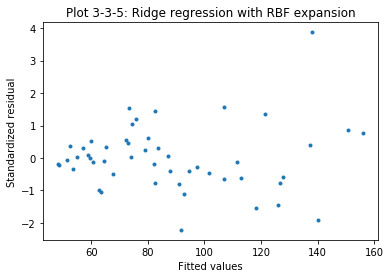

In [23]:
"""RBF Expansion"""
# number of RBF
n_rbf = 5

# locations and scale
z = np.linspace(0, 1, n_rbf)
sigma = 0.01 # same scale for each RBF

"""Normalize the data"""
row_sums = np.amax(X_real, axis=0)
new_matrix = (X_real / row_sums)
# print(new_matrix)
x_real1 = new_matrix
x_synth_rbf = expand_1d_to_RBF(x_real1[:,0], z, sigma).T
# print(x_real1.shape)
# print(x_synth_rbf.shape)
for i in range(1, x_real1.shape[1]):
    x_expand_column = expand_1d_to_RBF(x_real1[:,i], z, sigma).T
    x_synth_rbf =  np.column_stack((x_synth_rbf, x_expand_column))
print(x_synth_rbf.shape)
x_dummy_rbf = np.ones(x_real1.shape[0])
X_synth_rbf = np.column_stack((x_dummy_rbf, x_synth_rbf))
l = 0.02
w_rbf = reg_least_squares_fit(X_synth_rbf, y_real, l)
SSR = sum((y_real-np.dot(X_synth_rbf,w_rbf))**2)
print('RBF SSR:',SSR)
print('w:',w_rbf.T)

f_real = np.dot(X_synth_rbf,w_rbf)
SSR_optimal = sum((y_real-f_real)**2)
plt.plot(f_real,(y_real-np.dot(X_synth_rbf,w_rbf))/np.std((y_real-np.dot(X_synth_rbf,w_rbf))),'.')
# print(w_optimal)
print('Best lamda value: ',l_optimal)
print('Best SSR value: ',SSR_optimal)
plt.ylabel('Standardized residual')
plt.xlabel('Fitted values')
plt.title('Plot 3-3-5: Ridge regression with RBF expansion')
residuals  = y_real - f_real
stan_residuals = (residuals*1.0) /np.std(residuals )

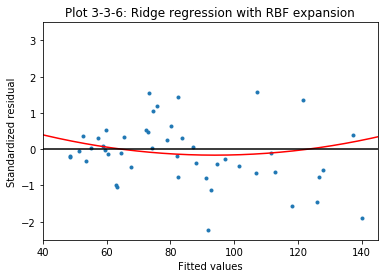

In [24]:
x_synth_poly = expand_1d_to_poly(f_real,2 )
x_dummy_poly = np.ones(f_real.shape)
X_synth_poly = np.column_stack((x_dummy_poly, x_synth_poly))
w_poly = least_squares_fit(X_synth_poly,stan_residuals)
SSR = sum((stan_residuals-np.dot(X_synth_poly,w_poly))**2)
# print(SSR)
# print(w_poly)
x_test_poly = np.linspace(0, 200, 50)[:, None]
x_test_poly1 = expand_1d_to_poly(x_test_poly,2)
x_test_dummy_poly = np.ones(x_test_poly.shape)
X_test_poly = np.column_stack((x_test_dummy_poly, x_test_poly1))
f_test_poly = np.dot(w_poly.T ,X_test_poly.T )[0][:,np.newaxis]
plt.plot(f_real, stan_residuals,'.')
plt.ylim([-2.5,3.5])
plt.xlim([40,145])
plt.plot(x_test_poly, f_test_poly, 'r')
plt.plot(x_test_poly, np.zeros(f_test_poly.size), 'black')
plt.ylabel('Standardized residual')
plt.xlabel('Fitted values')
plt.title('Plot 3-3-6: Ridge regression with RBF expansion')

In plot 3-3-6 above, the mean residual and spread doesn't change with the fitted values, which shows that the model has no problem. Comparing with plot 3-3-4 and 3-3-2, the plot of the quadratic function in plot 3-3-6 is much closer to the black line(a straight line), which indicates that the residual of the model is evenly distributed without much hidden relationship with the fitted value. 

To sum up, the linear regression with RBF model is relatively the most adequate for the dataset.

**Last thinkings:**

The result looks reasonable. But there are still a few problems which needs to be improved in this process.
1. Polynomial regression in section 2.1 should not be used directly without any changes in 3.3. For example, for features f = [f1,f2], the polynomial expension result should be fa' = [f1,f1^2,f2,f2^2,f1*f2] instead of fb' = [f1,f1^2,f2,f2^2]. The expension in fb' is still more effective comparing to f but less effective than fa'.

2. The 'l' parameter should be selected using test data instead of training data. According to the last plot in section 2.3, the SSR error value increases as the increase of 'l' parameter for training data.By using training data, the best 'l' will always be the smallest value. It is better to use held-out validation for 'l' parameter selection. Although according to the discussion board, we do not need to implement it :(

** Thank you so much for reading my assignment. **